In [444]:
!pip install squarify
!pip install wordcloud
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import squarify 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud
%matplotlib inline
sns.set_style('darkgrid')

In [445]:
### Loading Data
data_file_path = 'C:/Users/78425/Desktop/Diplomatura/Modulo1/Primer_Ejercicio/data.csv'
tag_file_path = 'C:/Users/78425/Desktop/Diplomatura/Modulo1/Primer_Ejercicio/tag.csv'
data = pd.read_csv(data_file_path)
tag = pd.read_csv(tag_file_path)

In [446]:
pd.set_option('display.max_columns',30)

In [447]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [448]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [449]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [450]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

In [451]:
tag.head()

,SUSCRIBER_KEY,Total
0,E_63734494_20190215,0
1,E_66977552_20190518,0
2,E_69159695_20180116,4
3,E_65255730_20190416,3
4,E_67893872_20161201,0


Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [452]:
tag['Total']= tag['Total']==0

In [453]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [454]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,True
1,E_66977552_20190518,True
2,E_69159695_20180116,False
3,E_65255730_20190416,False
4,E_67893872_20161201,True


In [455]:
tag['Target'] = tag['Target'].astype(int)

In [456]:
tag.head(5)

,SUSCRIBER_KEY,Target
0,E_63734494_20190215,1
1,E_66977552_20190518,1
2,E_69159695_20180116,0
3,E_65255730_20190416,0
4,E_67893872_20161201,1


In [457]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

 Unimos los datasets

In [458]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


In [459]:
del tag
del data

In [460]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 213 entries, SUSCRIBER_KEY to Target
dtypes: float64(103), int32(1), int64(97), object(12)
memory usage: 520.0+ MB


 ## Empecemos a limpiar columnas 

Todas las que dicen en el documento 'No se usa', Chau

In [461]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

In [462]:
fulldata.head()

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12,Target
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0,1
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14,1


Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [463]:
que_quedaron= ["USE_LCL_VOI_AMT_M1",
"USE_LCL_VOI_AMT_M2",
"USE_LCL_VOI_AMT_M3",]

In [464]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [465]:
fulldata.shape

(319222, 192)

In [466]:
print(fulldata.columns)

Index(['SUSCRIBER_KEY', 'FECHA_CORTE', 'LAT_PROV_BTS', 'LON_PROV_BTS',
       'LAT_CITY_BTS', 'LON_CITY_BTS', 'VALUE_SEGMENT', 'SEGMENTATION',
       'MICROSEGMENTATION', 'SOURCE',
       ...
       'PACK_DATA_EXP_W4', 'PACK_DATA_EXP_W5', 'PACK_DATA_EXP_W6',
       'PACK_DATA_EXP_W7', 'PACK_DATA_EXP_W8', 'PACK_DATA_EXP_W9',
       'PACK_DATA_EXP_W10', 'PACK_DATA_EXP_W11', 'PACK_DATA_EXP_W12',
       'Target'],
      dtype='object', length=192)


# ME HABÍAN QUEDADO LAS QUE TIENEN UN SOLO VALOR (OJO!!!) 

In [467]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [468]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [469]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

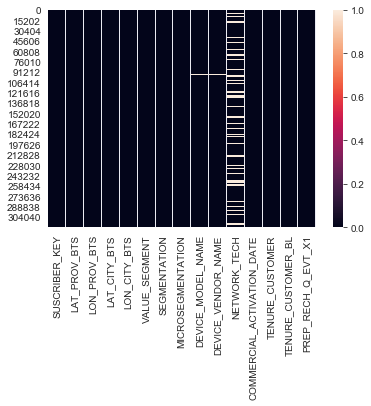

In [470]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [471]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [472]:
missing = pd.Series(nullcount)

In [473]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

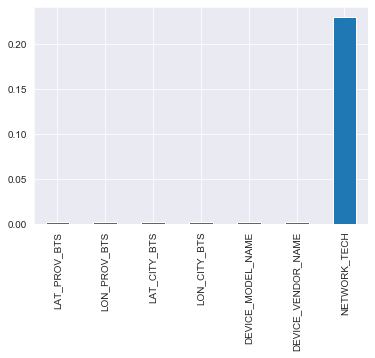

In [474]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

In [475]:
fulldata.shape[0]

319222

# Limpieza de datos categoricos

Analizamos los datos categoricos

In [476]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int32(1), int64(97), object(10)
memory usage: 464.0+ MB


In [477]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [478]:
cat_columns

['DEVICE_VENDOR_NAME',
 'VALUE_SEGMENT',
 'SUSCRIBER_KEY',
 'MICROSEGMENTATION',
 'COMMERCIAL_ACTIVATION_DATE',
 'SEGMENTATION',
 'NETWORK_TECH',
 'PREP_RECH_CHNNL_MODE12W',
 'PREP_RECH_LAST_DAY_12W',
 'DEVICE_MODEL_NAME']

In [479]:
Cat_fulldata =  fulldata[['SEGMENTATION',
 'PREP_RECH_CHNNL_MODE12W',
 'DEVICE_MODEL_NAME',
 'COMMERCIAL_ACTIVATION_DATE',
 'PREP_RECH_LAST_DAY_12W',
 'DEVICE_VENDOR_NAME',
 'MICROSEGMENTATION',
 'NETWORK_TECH',
 'SUSCRIBER_KEY',
 'VALUE_SEGMENT']].copy()

In [480]:
Cat_fulldata.head(5)

,SEGMENTATION,PREP_RECH_CHNNL_MODE12W,DEVICE_MODEL_NAME,COMMERCIAL_ACTIVATION_DATE,PREP_RECH_LAST_DAY_12W,DEVICE_VENDOR_NAME,MICROSEGMENTATION,NETWORK_TECH,SUSCRIBER_KEY,VALUE_SEGMENT
0,2-PD,"N/A,3;UGW,9",G4 STYLUS (H540),15-FEB-19,19-AUG-19,LG,PD1,LTE,E_63734494_20190215,3 - SILVER
1,7-LOW,"UGW,1",NOT_IDENTIFIED,18-MAY-19,03-JUL-19,NOT_IDENTIFIED,LOW3,NaN,E_66977552_20190518,4 - BRONZE
2,6-OH,"N/A,3;UGW,4",NOT_IDENTIFIED,16-JAN-18,02-SEP-19,NOT_IDENTIFIED,LOW4,3G,E_69159695_20180116,3 - SILVER
3,7-LOW,"UGW,2",JENNY TV 2.8,16-APR-19,01-SEP-19,BLU,LOW3,LTE,E_65255730_20190416,3 - SILVER
4,3-DO,"N/A,1;UGW,4",GALAXY J1 (SM-J111MDS),01-DEC-16,05-SEP-19,SAMSUNG,DO3,LTE,E_67893872_20161201,3 - SILVER


In [485]:
len(Cat_fulldata.DEVICE_MODEL_NAME.unique())

2477

Logramos identificar que las columas network tech, device vendor model y device vendor name tienen valores nulos ya sea como 'NaN' o como 'NOT_IDENTIFIED'. Por eso decidimos imputarlos..

## Imputar network tech

In [396]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467399
3G     0.272118
NaN    0.229959
2G     0.030524
Name: NETWORK_TECH, dtype: float64

Vemos que dentro de los valores tenemos un 22% que son NaN

In [397]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    149204
3G      86866
NaN     73408
2G       9744
Name: NETWORK_TECH, dtype: int64

Calculamos la moda de la columna NETWORK_TECH para luego reemplazarla por los valores NaN

In [398]:
moda_network_tech=fulldata['NETWORK_TECH'].mode()
moda_network_tech[0]

'LTE'

In [399]:
fulldata['NETWORK_TECH'].fillna(moda_network_tech[0], inplace=True)

In [400]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.697358
3G     0.272118
2G     0.030524
Name: NETWORK_TECH, dtype: float64

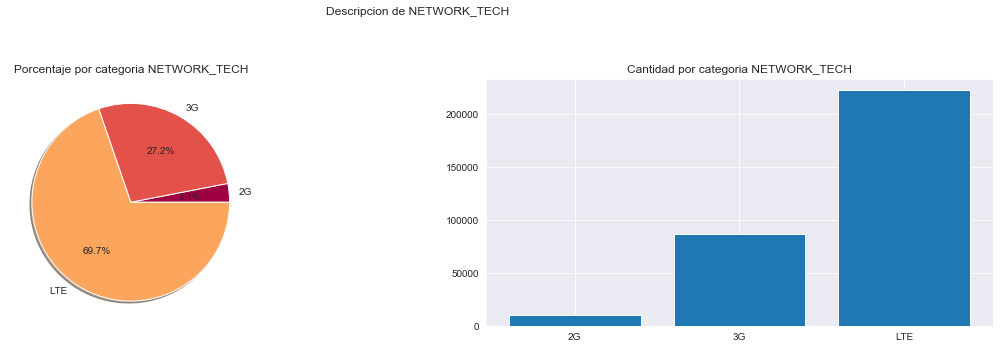

In [401]:
pie_labels=fulldata['NETWORK_TECH'].sort_values().unique()
pie_data_cantidad=fulldata['NETWORK_TECH'].value_counts(dropna=False).sort_values()
pie_data_porcentaje=fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False).sort_values()
#explode= (0,0.1,0)
plt.figure(1,figsize=(20,10))
the_grid=GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors=[cmap(i) for i in np.linspace(0,1,8)]
#Grafico de cantidades de NETWORK_TECH
plt.subplot(the_grid[0,1], title='Cantidad por categoria NETWORK_TECH')
cantidades_pie=plt.bar(pie_labels ,pie_data_cantidad)
#Grafico de porcentajes de NETWORK_TECH
plt.subplot(the_grid[0,0], title='Porcentaje por categoria NETWORK_TECH')
porcentaje_pie=plt.pie(pie_data_porcentaje, labels=pie_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.suptitle('Descripcion de NETWORK_TECH')

plt.show()

Vemos que el 22% de NaN paso a LTE 

## Imputar device model name

In [402]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

NOT_IDENTIFIED                           0.134881
GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.105281
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
                                           ...   
SGH-T739                                 0.000003
XPERIA Z5 (E6603)                        0.000003
MATE 20 PRO (LYA-L09)                    0.000003
GALAXY CORE PRIME (SM-G360H)             0.000003
2600B                                    0.000003
Name: DEVICE_MODEL_NAME, Length: 2477, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_MODEL_NAME son 'NOT_IDENTIFIED', con lo cual procedemos a inputar los datos por el valor de la moda.

In [403]:
device_model_name=fulldata[fulldata['DEVICE_MODEL_NAME']!='NOT_IDENTIFIED']
moda_device_model_name=device_model_name.DEVICE_MODEL_NAME.mode()
moda_device_model_name[0]

'GALAXY GRAND PRIME DUOS (SM-G532M DS)'

In [404]:
fulldata['DEVICE_MODEL_NAME'].replace({'NOT_IDENTIFIED':moda_device_model_name[0]},inplace=True)

In [405]:
fulldata['DEVICE_MODEL_NAME'].fillna(moda_device_model_name[0], inplace=True)

In [406]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.242916
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
GALAXY J2 PRIME (SM-G532M)               0.020259
                                           ...   
D250 UNIQ                                0.000003
6133                                     0.000003
E415 ONYX                                0.000003
X6D                                      0.000003
GALAXY GRAND PRIME (SM-G530H DV)         0.000003
Name: DEVICE_MODEL_NAME, Length: 2475, dtype: float64

Vemos que los valores de 'NOT_IDENTIFIED' se reemplazaron por la moda.

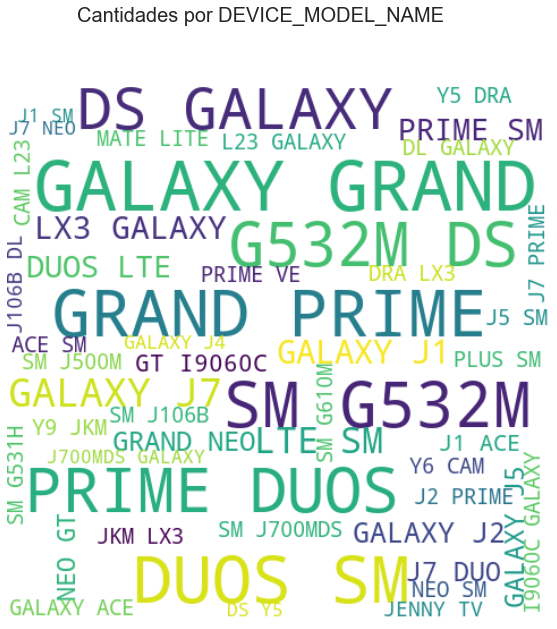

In [407]:
text=' '.join(fulldata['DEVICE_MODEL_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=50).generate(text)

plt.figure(1,figsize=(20,10))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_MODEL_NAME', fontsize=20)
plt.show()


## Imputar device vendor name

In [408]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG           0.502356
HUAWEI            0.173418
NOT_IDENTIFIED    0.134881
LG                0.051610
BLU               0.030712
                    ...   
LAKIA             0.000003
GFEN              0.000003
ALFATEL           0.000003
OBEE              0.000003
UTIME             0.000003
Name: DEVICE_VENDOR_NAME, Length: 234, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_V.ENDOR_NAME son 'NOT_IDENTIFIED', por lo que procedemos a reemplazar los valores por la moda 

In [409]:
device_vendor_name=fulldata[fulldata['DEVICE_VENDOR_NAME']!='NOT_IDENTIFIED']
moda_device_vendor_name=device_vendor_name.DEVICE_VENDOR_NAME.mode()
moda_device_vendor_name[0]

'SAMSUNG'

In [410]:
fulldata['DEVICE_VENDOR_NAME'].replace({'NOT_IDENTIFIED':moda_device_vendor_name[0]},inplace=True)

In [411]:
fulldata['DEVICE_VENDOR_NAME'].fillna(moda_device_vendor_name[0], inplace=True)

In [412]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG    0.639990
HUAWEI     0.173418
LG         0.051610
BLU        0.030712
NOKIA      0.026953
             ...   
JINGWAH    0.000003
TAXCEL     0.000003
OPTION     0.000003
MOVI       0.000003
JINPENG    0.000003
Name: DEVICE_VENDOR_NAME, Length: 232, dtype: float64

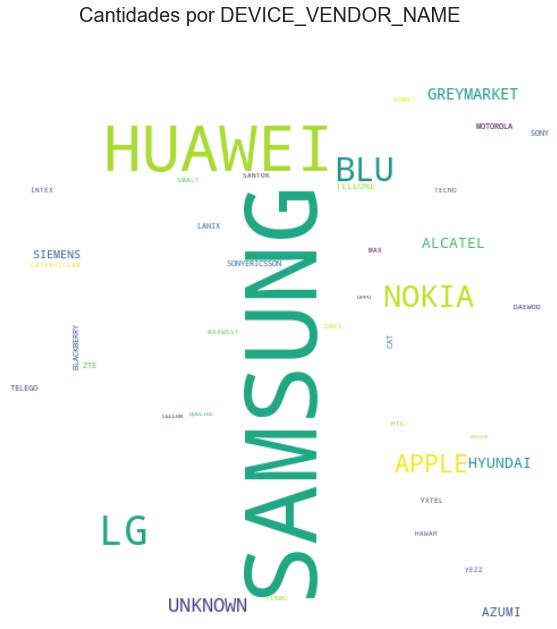

In [413]:
text=' '.join(fulldata['DEVICE_VENDOR_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=40).generate(text)

plt.figure(1,figsize=(10,10))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_VENDOR_NAME', fontsize=20)
plt.show()


Los valores de NOT_IDENTIFIED fueron reemplazados por su moda, que en este caso es 'SAMSUNG'.

# Limpieza de datos numericos

Ahora procedemos a limpiar los datos numericos, para esto separamos el data set en datos referidos a las recargas, pack y a trafico de datos.

## Limpieza de datos de Pack

Primero separamos las columnas que son de datos referidos a los packs

In [414]:
Pack_columns=['SUSCRIBER_KEY']
for a in cols:
    if a.startswith('PACK_'):
        Pack_columns.append(a)

In [415]:
Pack_fulldata=fulldata[Pack_columns]
Pack_fulldata

,SUSCRIBER_KEY,PACK_DATA_Q_X1,PACK_DATA_Q_X2,PACK_DATA_Q_X3,PACK_DATA_AMT_X1,PACK_DATA_AMT_X2,PACK_DATA_AMT_X3,PACK_VOICE_Q_X1,PACK_VOICE_Q_X2,PACK_VOICE_Q_X3,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_X3,PACK_SMS_Q_X1,PACK_SMS_Q_X2,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,4,5,4,6.00,9.0,6.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,0,0,0,0.00,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,5,3,3,4.50,3.0,1.50,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,3,0,0,0.99,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,3,4,3,8.99,9.0,10.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,0,0,4,0.00,0.0,4.99,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,3,10,0
319218,E_65347728_20171017,3,5,7,3.00,6.0,10.48,4,4,7,3.98,3.98,9.95,0,0,...,0.0,0.0,0.0,0,0,0,8,9,0,4,11,10,7,13,7
319219,E_68063707_20150701,0,0,0,0.00,0.0,0.00,0,3,0,0.00,1.99,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
319220,E_67206080_20181010,0,0,3,0.00,0.0,5.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,5,12


Comparamos las columnas de pack semanal contra las mensuales para buscar datos incorrectos o verificar si la informacion es duplicada.

### Para la cantidad de pack de datos :

In [416]:
Pack_fulldata[['PACK_DATA_Q_W1','PACK_DATA_Q_W2','PACK_DATA_Q_W3','PACK_DATA_Q_W4','PACK_DATA_Q_X1','PACK_DATA_Q_W5','PACK_DATA_Q_W6','PACK_DATA_Q_W7','PACK_DATA_Q_W8','PACK_DATA_Q_X2','PACK_DATA_Q_W9','PACK_DATA_Q_W10','PACK_DATA_Q_W11','PACK_DATA_Q_W12','PACK_DATA_Q_X3']]

,PACK_DATA_Q_W1,PACK_DATA_Q_W2,PACK_DATA_Q_W3,PACK_DATA_Q_W4,PACK_DATA_Q_X1,PACK_DATA_Q_W5,PACK_DATA_Q_W6,PACK_DATA_Q_W7,PACK_DATA_Q_W8,PACK_DATA_Q_X2,PACK_DATA_Q_W9,PACK_DATA_Q_W10,PACK_DATA_Q_W11,PACK_DATA_Q_W12,PACK_DATA_Q_X3
0,0,0,3,3,4,3,4,0,0,5,4,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,3,5,0,3,0,0,3,0,0,3,0,3
3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,3,0,3,0,3,4,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4
319218,0,0,0,3,3,3,0,0,4,5,3,3,4,3,7
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3


Vemos que hay inconsistencias entre las cantidades semanales y las mensuales, por ende la informacion es incorrecta.
Eliminamos las columnas con la premisa de no meter basura en el modelo.

In [417]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_Q' in x],inplace=True)

### Para los montos de pack de datos:

In [418]:
montos_pack_datos=Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_X1','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_X2','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12','PACK_DATA_AMT_X3']]
montos_pack_datos

,PACK_DATA_AMT_W1,PACK_DATA_AMT_W2,PACK_DATA_AMT_W3,PACK_DATA_AMT_W4,PACK_DATA_AMT_X1,PACK_DATA_AMT_W5,PACK_DATA_AMT_W6,PACK_DATA_AMT_W7,PACK_DATA_AMT_W8,PACK_DATA_AMT_X2,PACK_DATA_AMT_W9,PACK_DATA_AMT_W10,PACK_DATA_AMT_W11,PACK_DATA_AMT_W12,PACK_DATA_AMT_X3
0,0.0,0.0,3.00,3.00,6.00,3.0,6.0,0.0,0.0,9.0,6.0,0.0,0.00,0.00,6.00
1,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,1.5,0.0,1.50,1.50,4.50,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.50,0.00,1.50
3,0.0,0.0,0.99,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
4,0.0,0.0,0.00,8.99,8.99,0.0,5.0,0.0,4.0,9.0,0.0,10.0,0.00,0.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.99,0.00,4.99
319218,0.0,0.0,0.00,3.00,3.00,1.5,0.0,0.0,4.5,6.0,1.5,1.5,4.50,2.98,10.48
319219,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
319220,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.00,5.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de datos.

In [419]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_AMT_X' in x],inplace=True)


Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

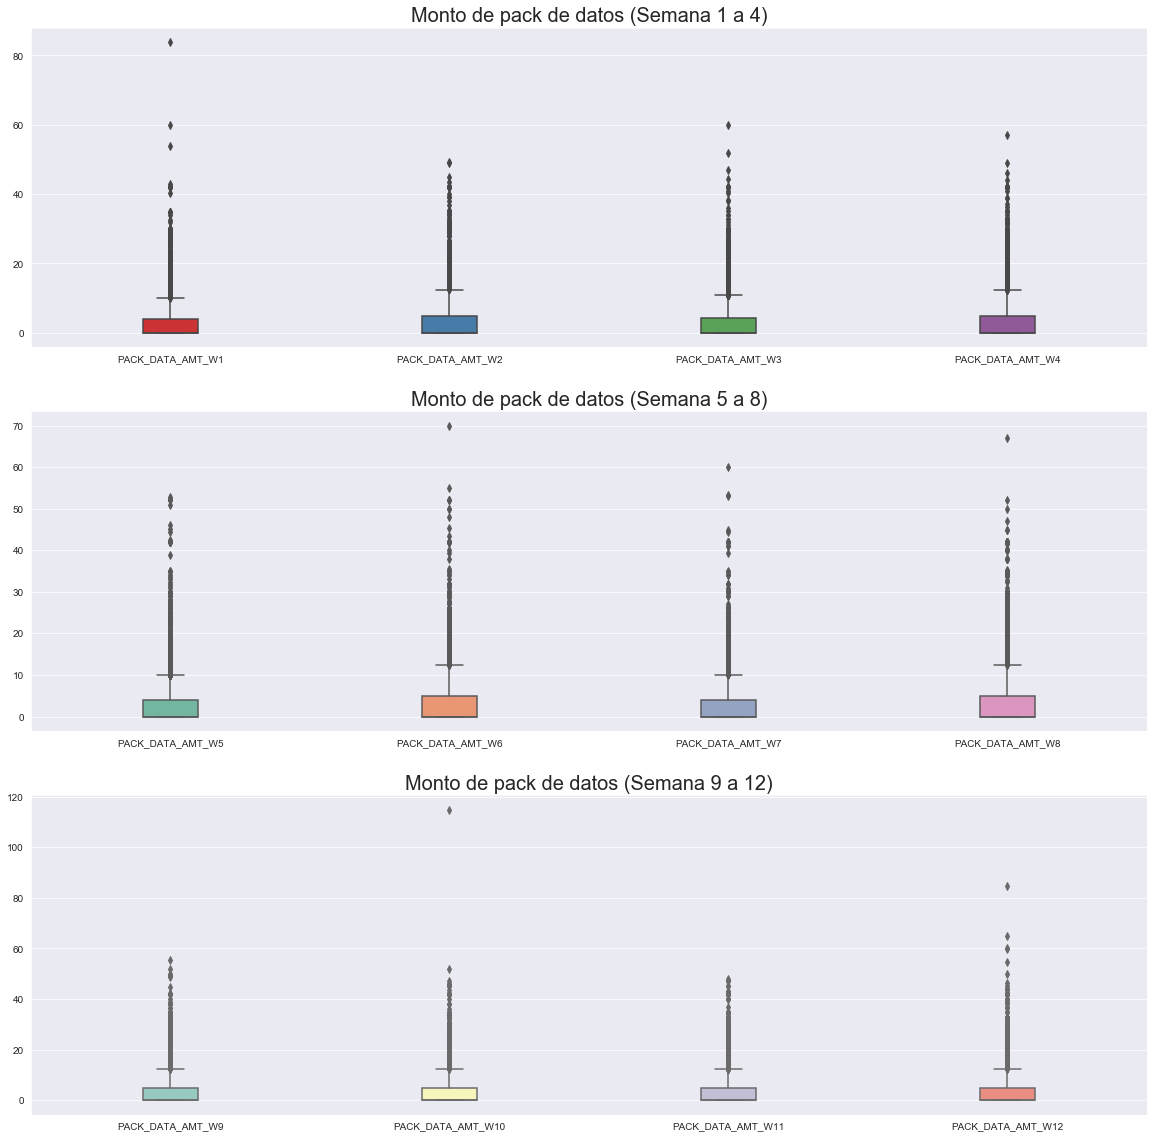

In [420]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=Pack_fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=Pack_fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)




Vemos que tenemos outliers por lo que procedemos a la eliminacion de los mismos segun esten en el primer o tercer quartil y multiplicando por 1.5 

In [421]:
for column in fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]:
    Q1 = fulldata[column].quantile(0.25)
    Q3 = fulldata[column].quantile(0.75)
    IQR = Q3 - Q1
    fulldata[column] = np.where((fulldata[column] < (Q1 - 1.5 * IQR)) | (fulldata[column] > (Q3 + 1.5 * IQR)), fulldata[column].median(), fulldata[column])


Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

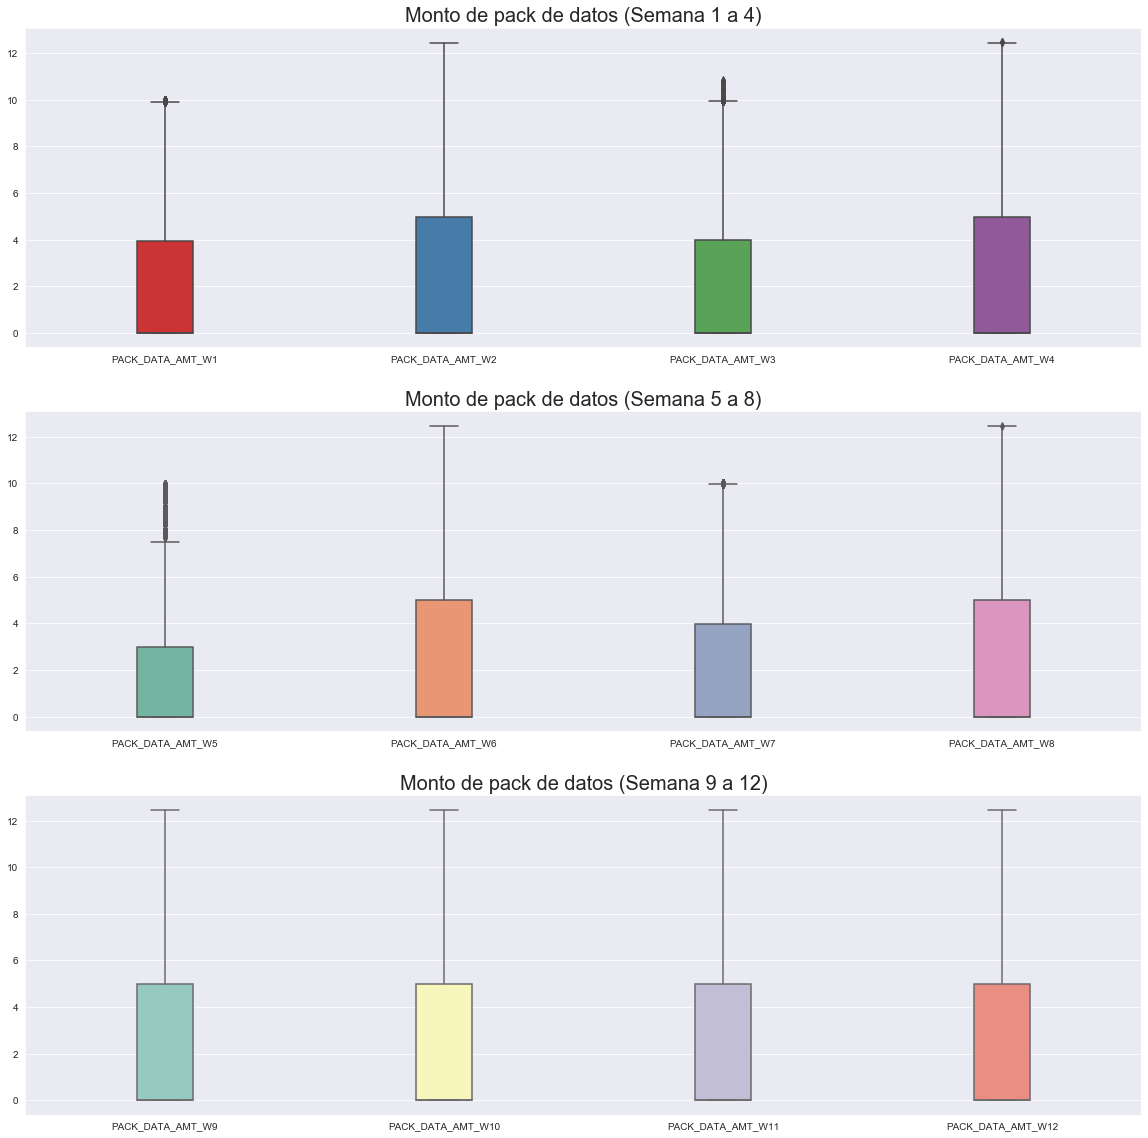

In [422]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)


### Para la cantidad de pack de sms:

In [423]:
Pack_fulldata[['PACK_SMS_Q_W1','PACK_SMS_Q_W2','PACK_SMS_Q_W3','PACK_SMS_Q_W4','PACK_SMS_Q_X1','PACK_SMS_Q_W5','PACK_SMS_Q_W6','PACK_SMS_Q_W7','PACK_SMS_Q_W8','PACK_SMS_Q_X2','PACK_SMS_Q_W9','PACK_SMS_Q_W10','PACK_SMS_Q_W11','PACK_SMS_Q_W12','PACK_SMS_Q_X3']]

,PACK_SMS_Q_W1,PACK_SMS_Q_W2,PACK_SMS_Q_W3,PACK_SMS_Q_W4,PACK_SMS_Q_X1,PACK_SMS_Q_W5,PACK_SMS_Q_W6,PACK_SMS_Q_W7,PACK_SMS_Q_W8,PACK_SMS_Q_X2,PACK_SMS_Q_W9,PACK_SMS_Q_W10,PACK_SMS_Q_W11,PACK_SMS_Q_W12,PACK_SMS_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vemos que las columnas de los pack de sms semanales no coinciden con el correspondiente acumulado mensual, por lo que se considera dato incorrecto y se elimina del dataset.

In [424]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_Q' in x],inplace=True)

### Para los montos en sms:

In [425]:
Pack_fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4','PACK_SMS_AMT_X1','PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8','PACK_SMS_AMT_X2','PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12','PACK_SMS_AMT_X3']]

,PACK_SMS_AMT_W1,PACK_SMS_AMT_W2,PACK_SMS_AMT_W3,PACK_SMS_AMT_W4,PACK_SMS_AMT_X1,PACK_SMS_AMT_W5,PACK_SMS_AMT_W6,PACK_SMS_AMT_W7,PACK_SMS_AMT_W8,PACK_SMS_AMT_X2,PACK_SMS_AMT_W9,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_SMS_AMT_X3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este caso los montos si coinciden, por lo cual se eliminan las columnas de acumulados para no repetir informacion.

In [426]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_AMT_X' in x],inplace=True)

Text(0.5, 1.0, 'Monto de pack de sms (Semana 9 a 12)')

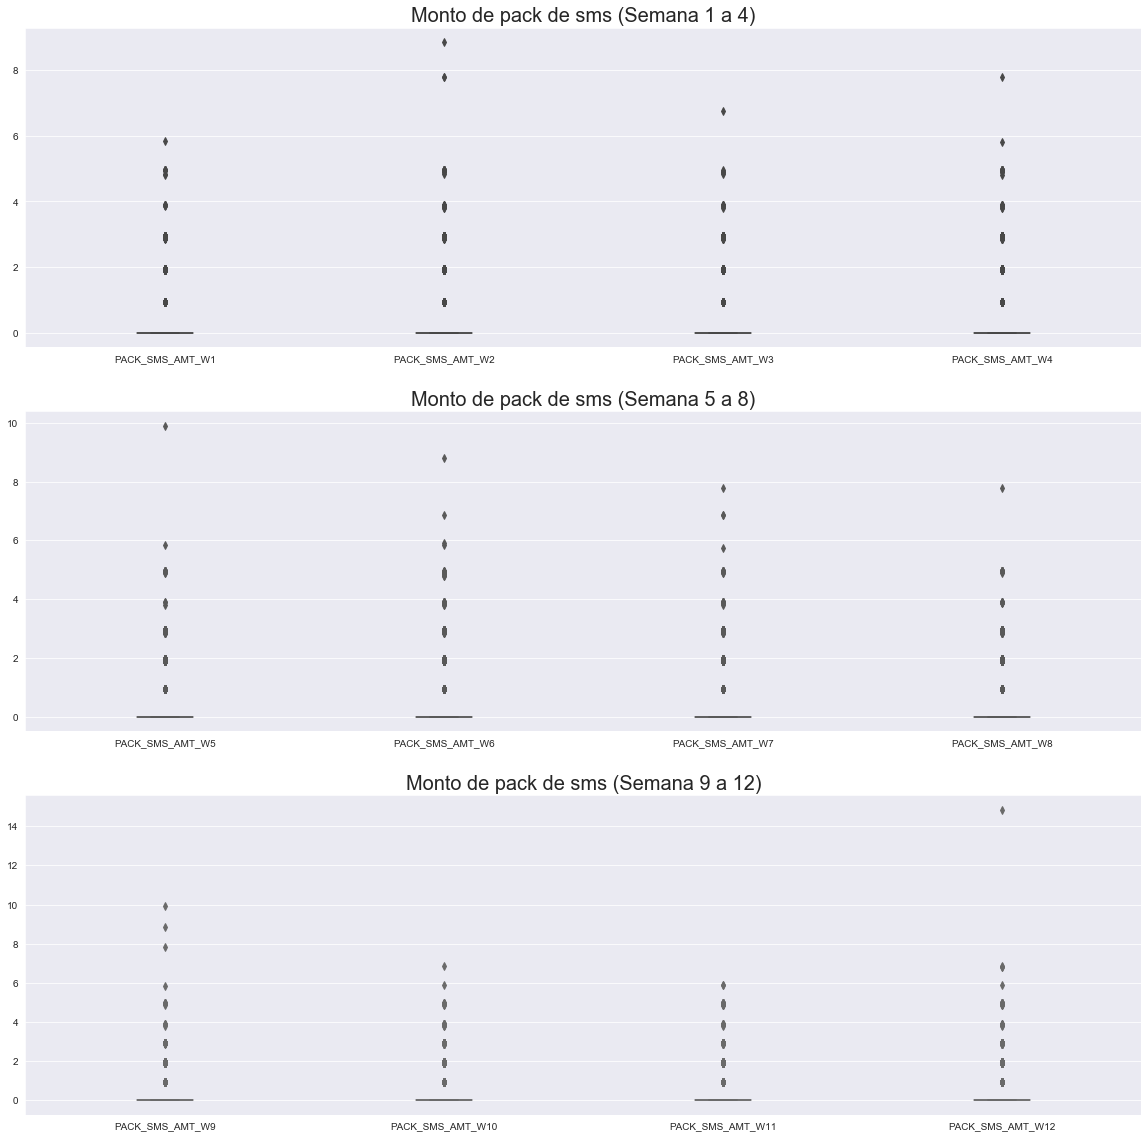

In [430]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=Pack_fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=Pack_fulldata[['PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=Pack_fulldata[['PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de sms (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de sms (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de sms (Semana 9 a 12)",fontsize=20)



Tambien vemos que existen outliers por lo que hacemos el mismo procedimiento de eliminacion anterior

In [345]:
sms_pack_columns=['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4','PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8','PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12']

In [359]:
for col in sms_pack_columns:
    print(col)
    print('   Con quartil 0.99',fulldata[fulldata[col]<=fulldata[col].quantile(0.99)].shape)
    print('   Con quartil 0.95',fulldata[fulldata[col]<=fulldata[col].quantile(0.95)].shape)
    print('   Con quartil 0.90',fulldata[fulldata[col]<=fulldata[col].quantile(0.80)].shape)



PACK_SMS_AMT_W1
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W2
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W3
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W4
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W5
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W6
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W7
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W8
   Con quartil 0.99 (319222, 154)
   Con quartil 0.95 (319222, 154)
   Con quartil 0.90 (319222, 154)
PACK_SMS_AMT_W9
   Con quartil 0.99 (319222, 154)
   Con

Vemos que a ojo con quartiles 99, 95 y 90 tenemos el mismo resultado por ende procedemos a usar cualquiera de los 3 para limpieza de outliers

In [357]:
for col in sms_pack_columns:
    fulldata.loc[fulldata[col]>fulldata[col].quantile(0.95),col] = fulldata[col].quantile(0.95)

Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

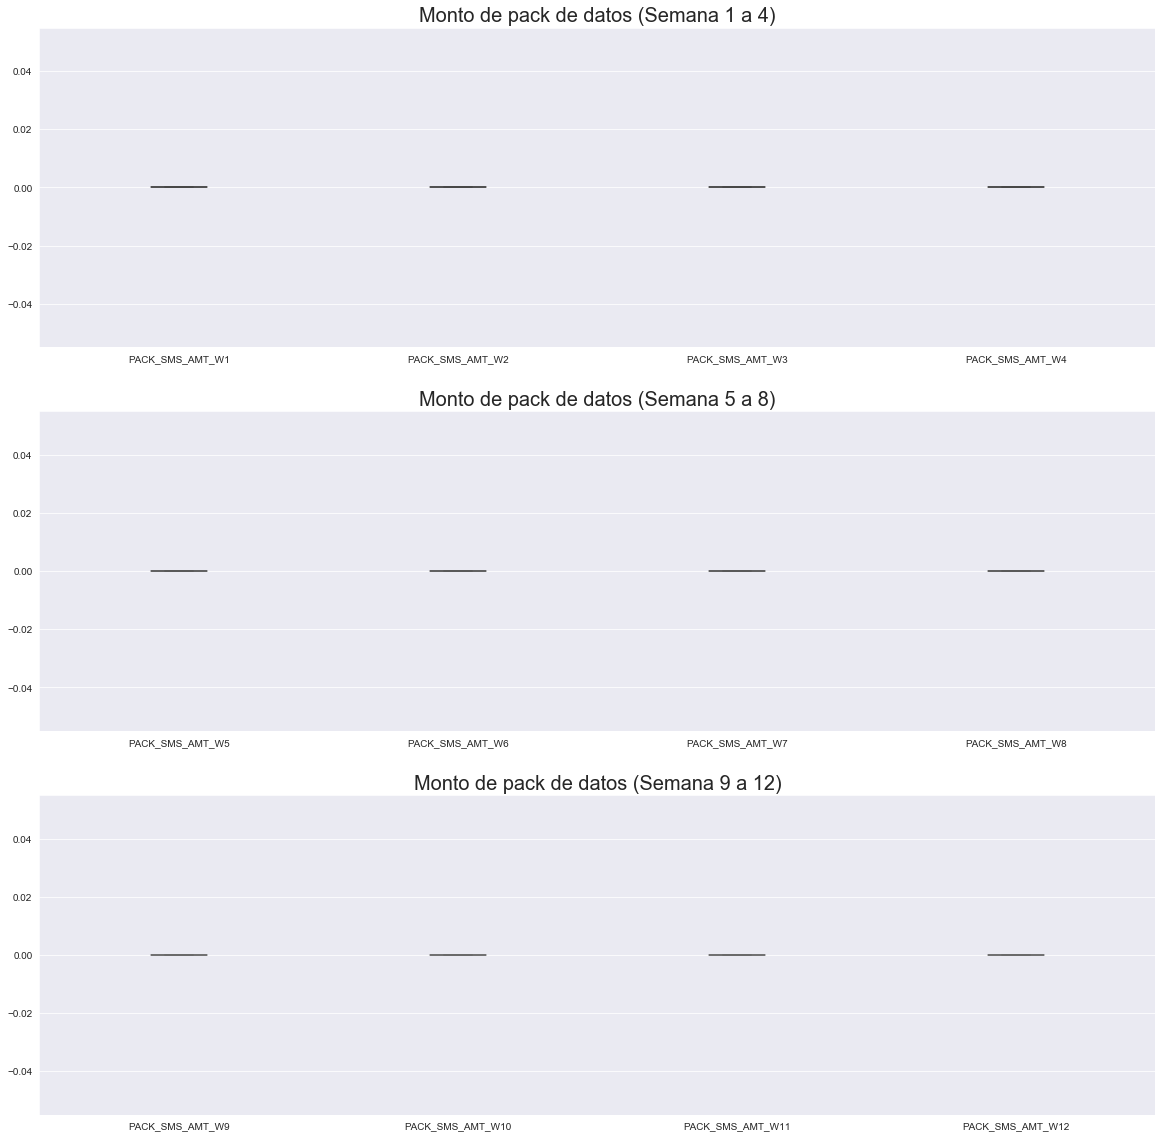

In [358]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=fulldata[['PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=fulldata[['PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)

### Para la cantidad de pack de voz:

In [168]:
Pack_fulldata[['PACK_VOICE_Q_W1','PACK_VOICE_Q_W2','PACK_VOICE_Q_W3','PACK_VOICE_Q_W4','PACK_VOICE_Q_X1','PACK_VOICE_Q_W5','PACK_VOICE_Q_W6','PACK_VOICE_Q_W7','PACK_VOICE_Q_W8','PACK_VOICE_Q_X2','PACK_VOICE_Q_W9','PACK_VOICE_Q_W10','PACK_VOICE_Q_W11','PACK_VOICE_Q_W12','PACK_VOICE_Q_X3']]

,PACK_VOICE_Q_W1,PACK_VOICE_Q_W2,PACK_VOICE_Q_W3,PACK_VOICE_Q_W4,PACK_VOICE_Q_X1,PACK_VOICE_Q_W5,PACK_VOICE_Q_W6,PACK_VOICE_Q_W7,PACK_VOICE_Q_W8,PACK_VOICE_Q_X2,PACK_VOICE_Q_W9,PACK_VOICE_Q_W10,PACK_VOICE_Q_W11,PACK_VOICE_Q_W12,PACK_VOICE_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,4,4,3,0,0,3,4,0,4,0,5,7
319219,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Aca vemos que las cantidades semanales no se corresponden con los acumulados mensuales, lo tomamos como valores incorrectos y procedemos a borrarlos

In [169]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_Q' in x],inplace=True)


### Para el monto de pack de voz:

In [170]:
Pack_fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_X1','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_X2','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12','PACK_VOICE_AMT_X3']]

,PACK_VOICE_AMT_W1,PACK_VOICE_AMT_W2,PACK_VOICE_AMT_W3,PACK_VOICE_AMT_W4,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_W5,PACK_VOICE_AMT_W6,PACK_VOICE_AMT_W7,PACK_VOICE_AMT_W8,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_W9,PACK_VOICE_AMT_W10,PACK_VOICE_AMT_W11,PACK_VOICE_AMT_W12,PACK_VOICE_AMT_X3
0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
4,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
319218,0.0,0.0,0.0,3.98,3.98,1.99,0.00,0.0,1.99,3.98,0.0,3.98,0.0,5.97,9.95
319219,0.0,0.0,0.0,0.00,0.00,0.00,1.99,0.0,0.00,1.99,0.0,0.00,0.0,0.00,0.00
319220,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de voz.

In [171]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_AMT_X' in x],inplace=True)

Text(0.5, 1.0, 'Monto de pack de voz (Semana 9 a 12)')

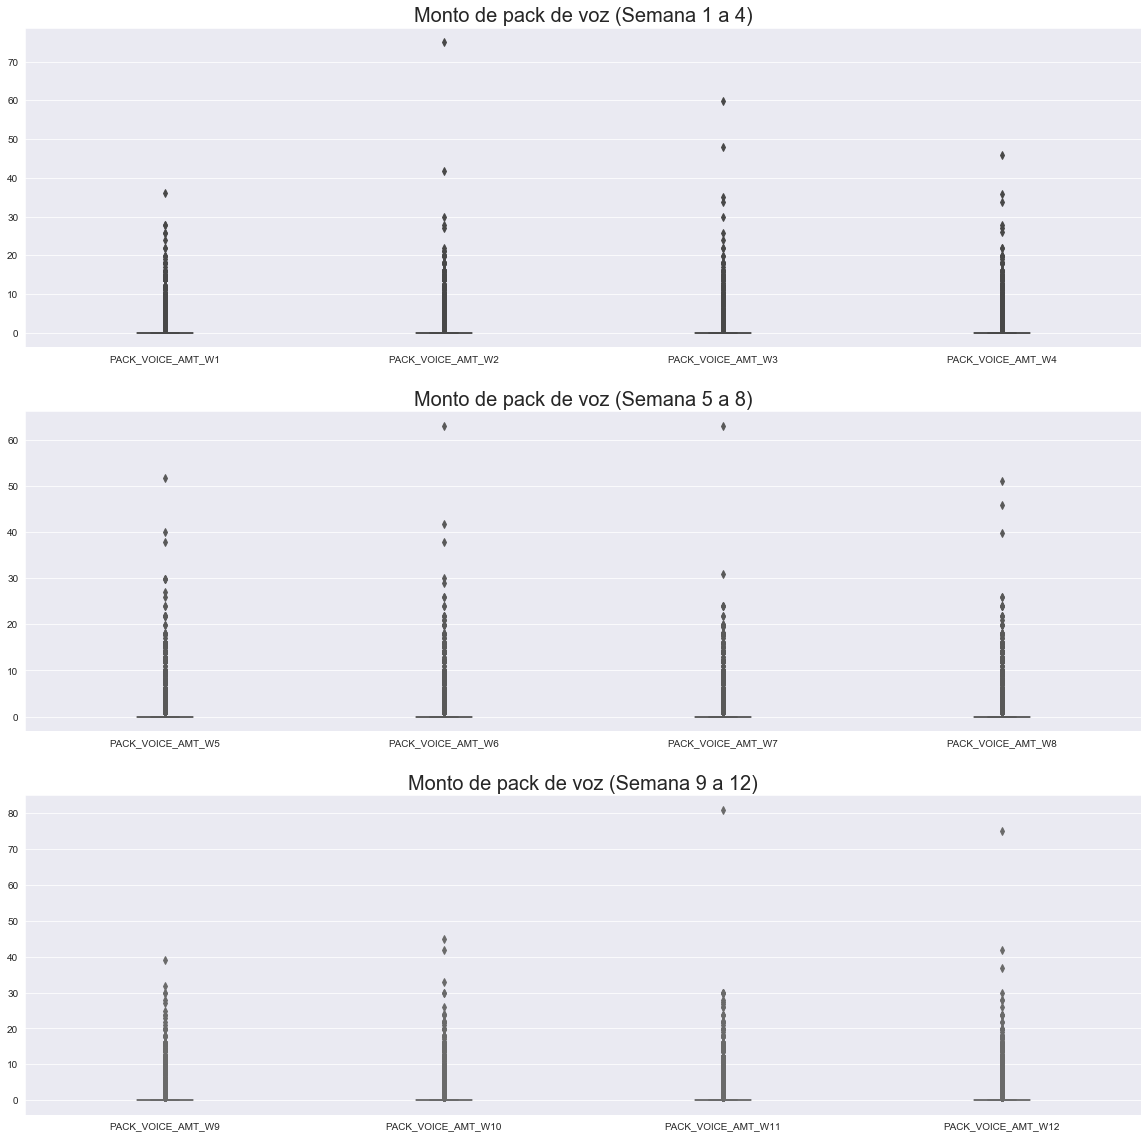

In [172]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=Pack_fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=Pack_fulldata[['PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=Pack_fulldata[['PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de voz (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de voz (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de voz (Semana 9 a 12)",fontsize=20)


In [173]:
for column in fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12']]:
    Q1 = fulldata[column].quantile(0.25)
    Q3 = fulldata[column].quantile(0.75)
    IQR = Q3 - Q1
    fulldata[column] = np.where((fulldata[column] < (Q1 - 1.5 * IQR)) | (fulldata[column] > (Q3 + 1.5 * IQR)), fulldata[column].median(), fulldata[column])


In [487]:
fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12']].describe()

,PACK_VOICE_AMT_W1,PACK_VOICE_AMT_W2,PACK_VOICE_AMT_W3,PACK_VOICE_AMT_W4,PACK_VOICE_AMT_W5,PACK_VOICE_AMT_W6,PACK_VOICE_AMT_W7,PACK_VOICE_AMT_W8,PACK_VOICE_AMT_W9,PACK_VOICE_AMT_W10,PACK_VOICE_AMT_W11,PACK_VOICE_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,0.381197,0.392962,0.422240,0.416100,0.433289,0.446945,0.455055,0.470535,0.454934,0.475178,0.498231,0.493901
std,1.369336,1.403767,1.479212,1.437346,1.500147,1.523503,1.536978,1.574561,1.529960,1.569962,1.618287,1.612425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,36.000000,75.000000,59.700000,45.770000,51.740000,63.000000,63.000000,51.000000,39.000000,45.000000,81.000000,75.000000


Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

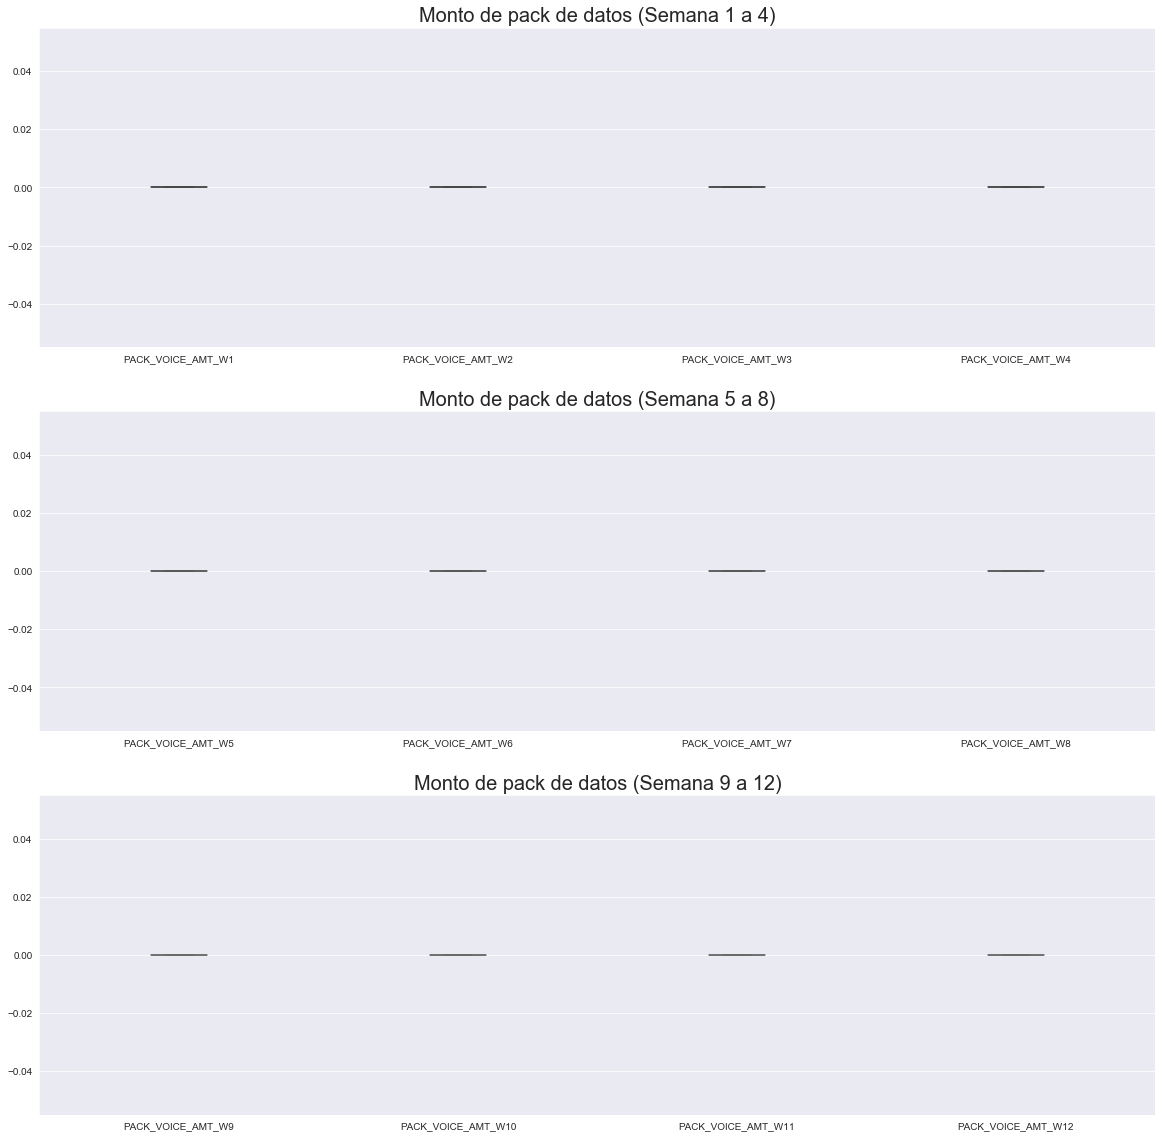

In [174]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=fulldata[['PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=fulldata[['PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)

In [175]:
fulldata.shape

(319222, 136)

## Limpieza de datos de tráfico



In [176]:
traffic_columns = [traffic_column for traffic_column in fulldata.columns if traffic_column.startswith("TR")]

In [177]:
len(traffic_columns)

33

#### Data frame solo con datos de tráfico

In [178]:
df_traffic = fulldata[traffic_columns].copy()

In [179]:
df_traffic.head()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,TRD_IM_M2,TRD_IM_M3,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,...,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,15.09,5.06,1.00,12538,1121,866,0,38,0,526,435,0,-13044.91,-1582.94,-863.00,...,4,0,0,139.53,188.6,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,...,0,0,0,0.00,0.0,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,0.42,0.00,0.09,57,0,0,0,0,0,244,0,67,-296.58,0.00,-64.91,...,0,0,0,1.38,0.0,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,0.14,0.00,0.00,7,0,0,65,0,0,54,0,0,-119.86,0.00,0.00,...,0,0,0,1.17,0.0,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,1.80,3.90,0.88,667,2078,83,128,110,9,562,710,599,-1349.20,-2888.10,-684.12,...,0,0,0,0.00,0.0,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0


#### Corroborar si algun datao es NaN o null

In [180]:
any(df_traffic.isna().sum() != 0) or any(df_traffic.isnull().sum() != 0)

False

# Selección de columnas

In [181]:
df_traffic.corr()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,TRD_IM_M2,TRD_IM_M3,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,...,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
TRD_M1,1.000000,0.819897,0.706444,0.880530,0.686740,0.589018,0.680411,0.576677,0.504866,0.593411,0.502507,0.448108,-0.981298,-0.800250,-0.692806,...,-0.021242,-0.057533,-0.065129,0.159353,0.129310,0.107154,0.134440,0.102743,0.077624,0.169570,0.137804,0.113377,-0.000773,-0.002232,-0.004701
TRD_M2,0.819897,1.000000,0.812299,0.704101,0.849376,0.686593,0.568637,0.671875,0.563763,0.512410,0.595429,0.509747,-0.801601,-0.968443,-0.796362,...,-0.032868,-0.056186,-0.064748,0.133303,0.151496,0.121957,0.113338,0.122002,0.090125,0.141943,0.161491,0.129081,-0.000854,0.001362,-0.001865
TRD_M3,0.706444,0.812299,1.000000,0.602125,0.678701,0.877616,0.503848,0.570486,0.665991,0.457710,0.512473,0.596622,-0.695895,-0.795132,-0.986586,...,-0.043088,-0.066985,-0.063218,0.114486,0.130443,0.147253,0.094316,0.101494,0.105583,0.121747,0.138817,0.155561,-0.004722,-0.003314,-0.003169
TRD_STR_M1,0.880530,0.704101,0.602125,1.000000,0.764232,0.642544,0.371446,0.312305,0.267777,0.308190,0.259361,0.226853,-0.895387,-0.697189,-0.598833,...,-0.023074,-0.048766,-0.054645,0.124488,0.101716,0.086616,0.076968,0.058092,0.039714,0.129685,0.105906,0.089213,0.000450,0.000482,-0.001999
TRD_STR_M2,0.686740,0.849376,0.678701,0.764232,1.000000,0.751853,0.282610,0.333055,0.274304,0.254250,0.292309,0.247053,-0.688090,-0.873509,-0.683380,...,-0.028640,-0.045830,-0.052192,0.103430,0.117191,0.096966,0.056978,0.065639,0.042894,0.107090,0.121827,0.099642,-0.000372,0.002228,-0.000502
TRD_STR_M3,0.589018,0.686593,0.877616,0.642544,0.751853,1.000000,0.249587,0.284675,0.334460,0.220446,0.246592,0.289303,-0.584096,-0.675700,-0.889388,...,-0.036244,-0.053864,-0.053334,0.086192,0.098773,0.114020,0.043531,0.051642,0.053253,0.088952,0.102413,0.117524,-0.003120,-0.001942,-0.002279
TRD_SN_M1,0.680411,0.568637,0.503848,0.371446,0.282610,0.249587,1.000000,0.844782,0.749215,0.455462,0.392779,0.361107,-0.702335,-0.592182,-0.511767,...,-0.040526,-0.060806,-0.063290,0.065883,0.049784,0.035954,0.088585,0.066330,0.049818,0.073528,0.056111,0.040727,-0.005767,-0.007249,-0.007717
TRD_SN_M2,0.576677,0.671875,0.570486,0.312305,0.333055,0.284675,0.844782,1.000000,0.844078,0.403161,0.459169,0.407923,-0.596455,-0.698510,-0.579305,...,-0.046167,-0.061316,-0.063912,0.052568,0.060817,0.043548,0.076208,0.078627,0.058169,0.059258,0.068211,0.049022,-0.006036,-0.006423,-0.007252
TRD_SN_M3,0.504866,0.563763,0.665991,0.267777,0.274304,0.334460,0.749215,0.844078,1.000000,0.359763,0.399823,0.460776,-0.523048,-0.588081,-0.678881,...,-0.051216,-0.066013,-0.063408,0.039130,0.045987,0.051734,0.063119,0.064802,0.066499,0.044817,0.052227,0.057883,-0.006818,-0.007302,-0.006473
TRD_IM_M1,0.593411,0.512410,0.457710,0.308190,0.254250,0.220446,0.455462,0.403161,0.359763,1.000000,0.843178,0.753157,-0.597036,-0.531478,-0.457750,...,0.014308,-0.022118,-0.029371,0.170838,0.142321,0.119294,0.159099,0.125445,0.102146,0.183313,0.153102,0.127902,-0.002409,-0.006056,-0.006909


Plotear un heatmap de 33x33 es inviable, vamos a separar por tipo de dato:
1. Tráfico de datos
   * Total
   * Streaming
   * Redes sociales
   * Internet
2. Número de SMS
3. Tiempo de llamadas de voz
Y cada uno de estos los vamos a agrupar por por mes, para evaluar la relación que hay entre un mismo tipo de consumo por mes.

# Correlación de variables de tráfico

## Tráfico de datos

#### Tráfico de datos agrupados por tipo

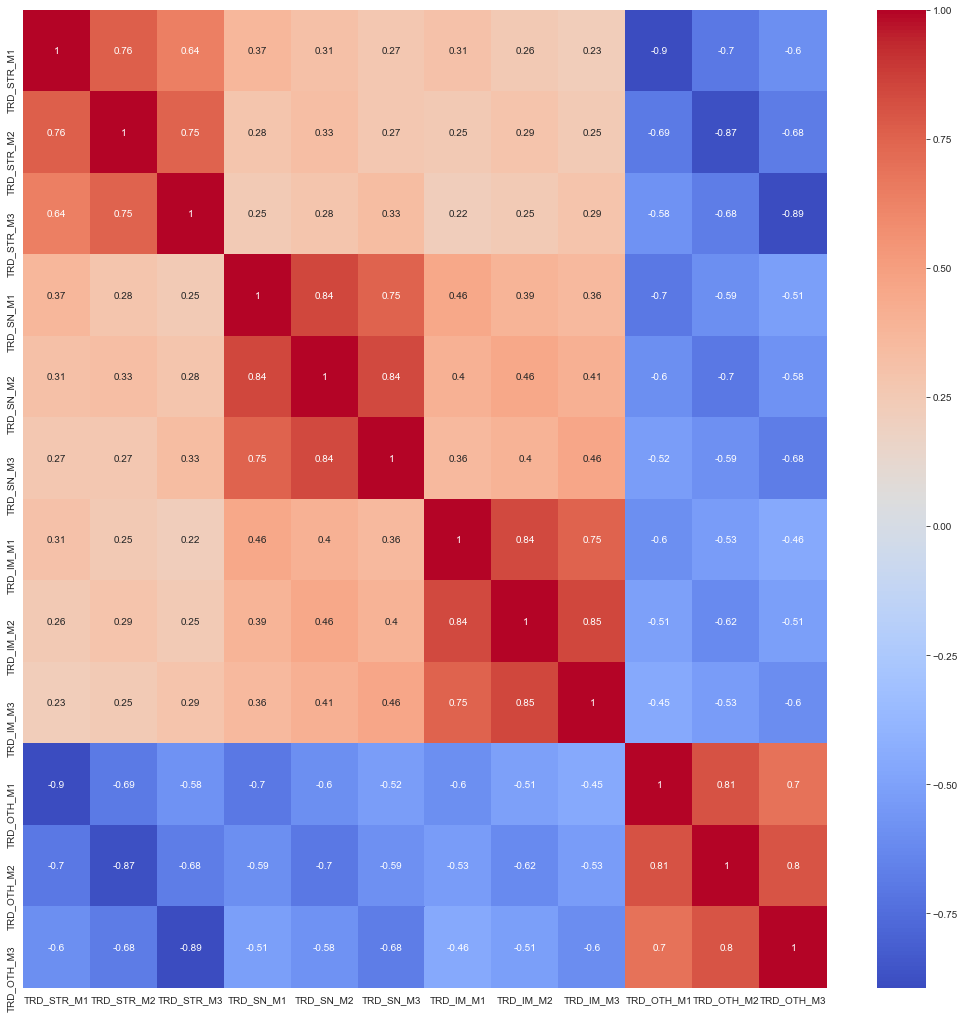

In [182]:
# FIXME: Corroborar que estas columnas tienen el total de los datos
total_data_columns = ['TRD_M1', 'TRD_M2', 'TRD_M3']
df_traffic_data_columns = [traffic_column for traffic_column in traffic_columns 
                           if traffic_column.startswith("TRD") 
                           and traffic_column not in  total_data_columns]
df_traffic_data_corr  = df_traffic[df_traffic_data_columns].corr()
# df_traffic_data_corr
plt.figure(figsize=(18, 18))
sns.heatmap(df_traffic_data_corr, annot=True, cmap='coolwarm')

Función que devuelve dos últimos elementos de iterable, en este caso mes de las columnas

In [183]:
get_month = lambda x: x[-2:]

#### Tráfico de datos agrupados por mes

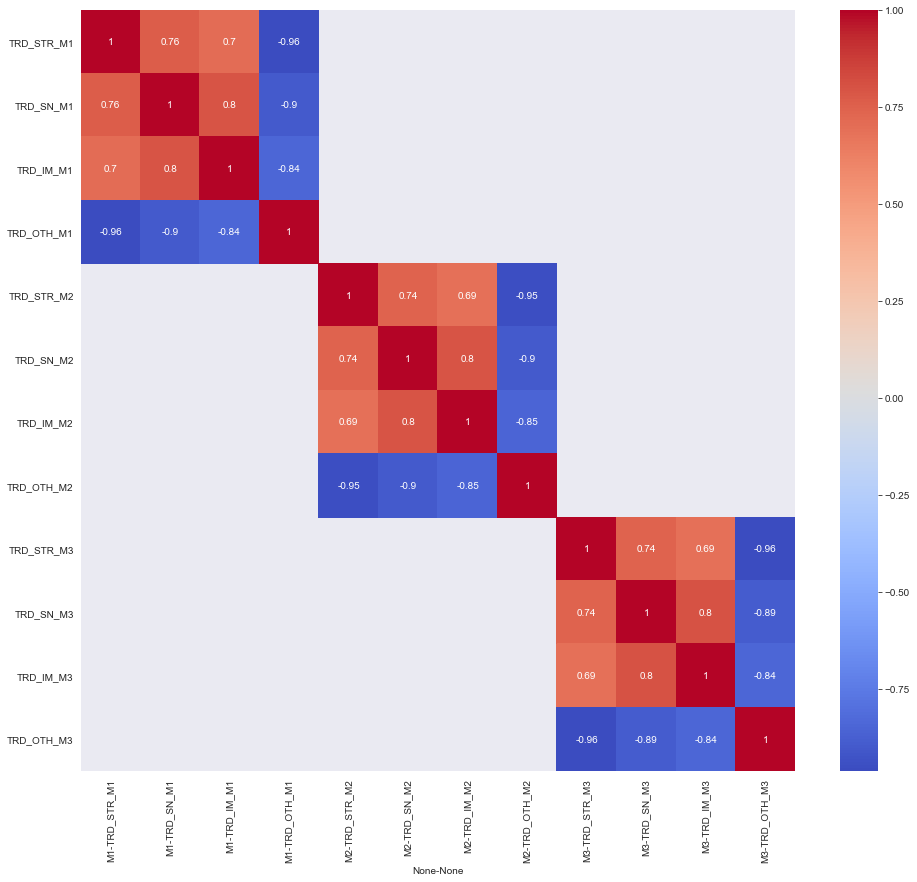

In [184]:
by_month_traffic_data_corr = df_traffic_data_corr.groupby(by=get_month, axis=1).corr()
# by_month_traffic_data_corr
plt.figure(figsize=(16, 14))
sns.heatmap(by_month_traffic_data_corr, annot=True, cmap='coolwarm')

### Las variables de consumo de datos agrupadas por mes tienen una correlación bastante alta por lo que se los puede agrupar por mes.

-----------

## Número de SMS

### Número de SMS agrupados por tipo

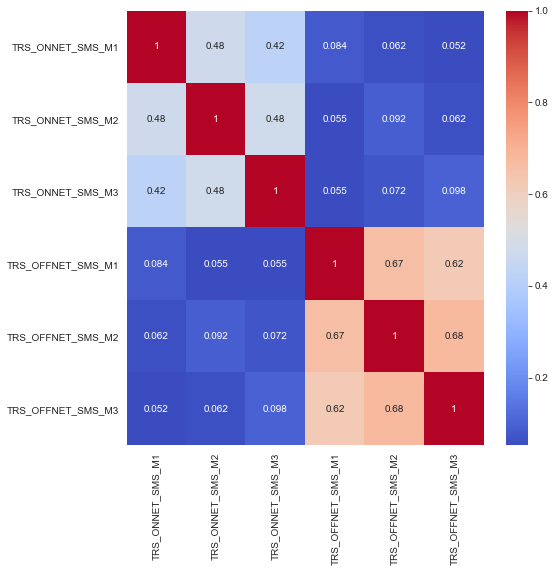

In [185]:
df_n_sms_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRS")]
df_n_sms_corr  = df_traffic[df_n_sms_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(df_n_sms_corr, annot=True, cmap='coolwarm')

### Número de SMS agrupados por mes

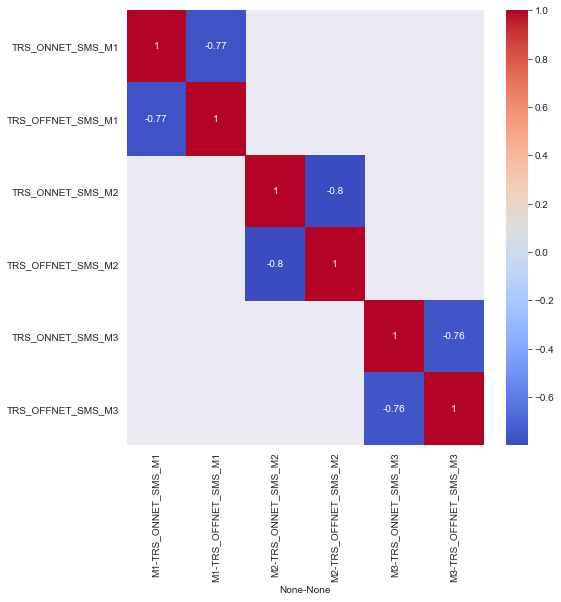

In [186]:
by_month_n_sms_corr = df_n_sms_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(by_month_n_sms_corr, annot=True, cmap='coolwarm')

In [187]:
df_traffic[df_n_sms_columns].describe()

,TRS_ONNET_SMS_M1,TRS_ONNET_SMS_M2,TRS_ONNET_SMS_M3,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,0.173415,0.185037,0.191791,1.216655,1.198780,1.216179
std,0.949936,0.983975,1.002220,2.403954,2.400983,2.459793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.000000,36.000000,36.000000,37.000000,38.000000,30.000000


### Como los datos de SMS están acumulados en torno a cero, se descartarán estas columnas

-------------------------------------

## Llamadas de voz

### Llamadas por voz agrupadas por tipo

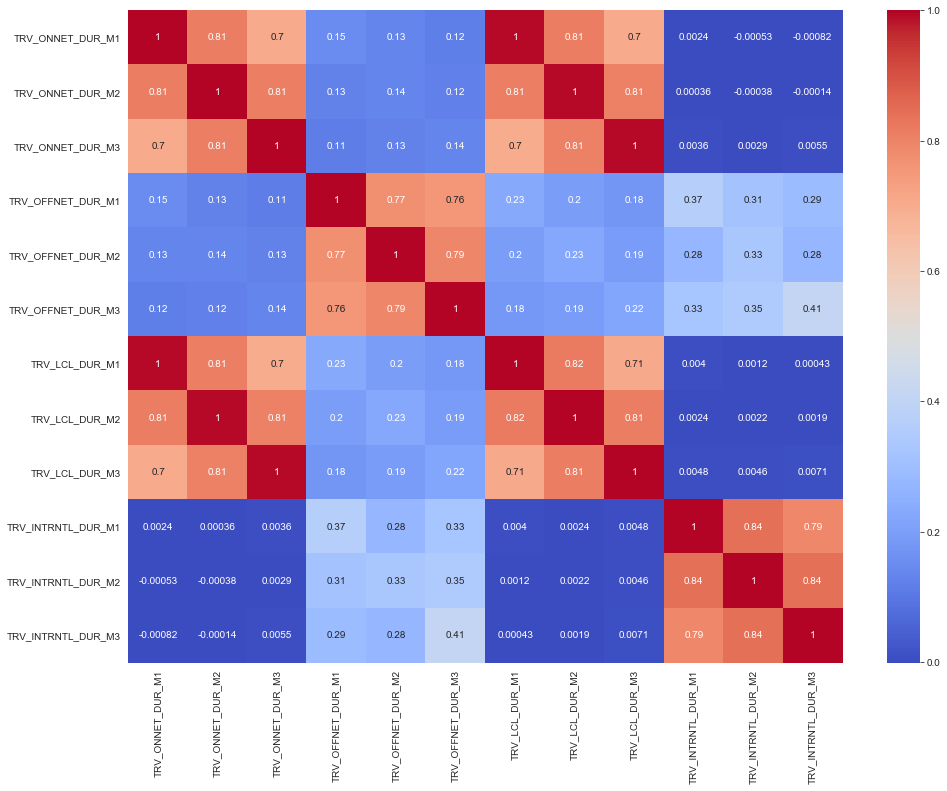

In [188]:
df_voice_minutes_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRV")]
df_voice_minutes_corr = df_traffic[df_voice_minutes_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_voice_minutes_corr, annot=True, cmap='coolwarm')

### Llamadas por voz agrupadas por mes

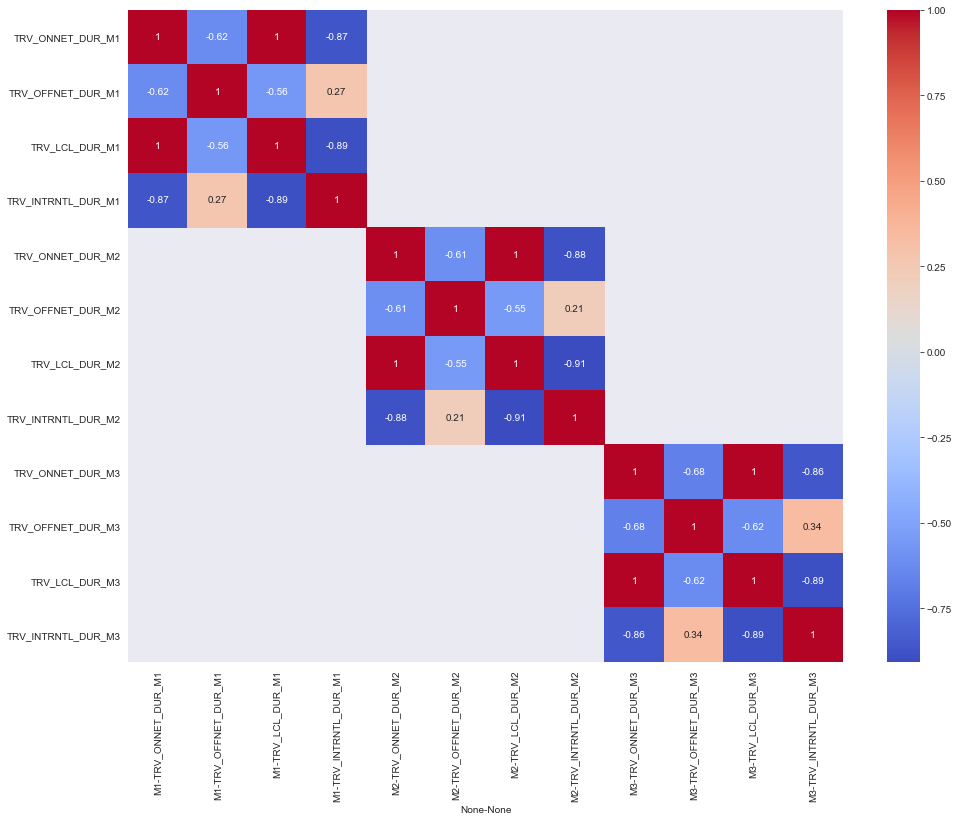

In [189]:
by_month_voice_minutes_corr = df_voice_minutes_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_voice_minutes_corr, annot=True, cmap='coolwarm')

### Las llamamdas tienen también una alta correlación entre sí por mes, por lo que se podrían agrupar por columnas por mes

--------------------------

# Outliers

## Tráfico de datos

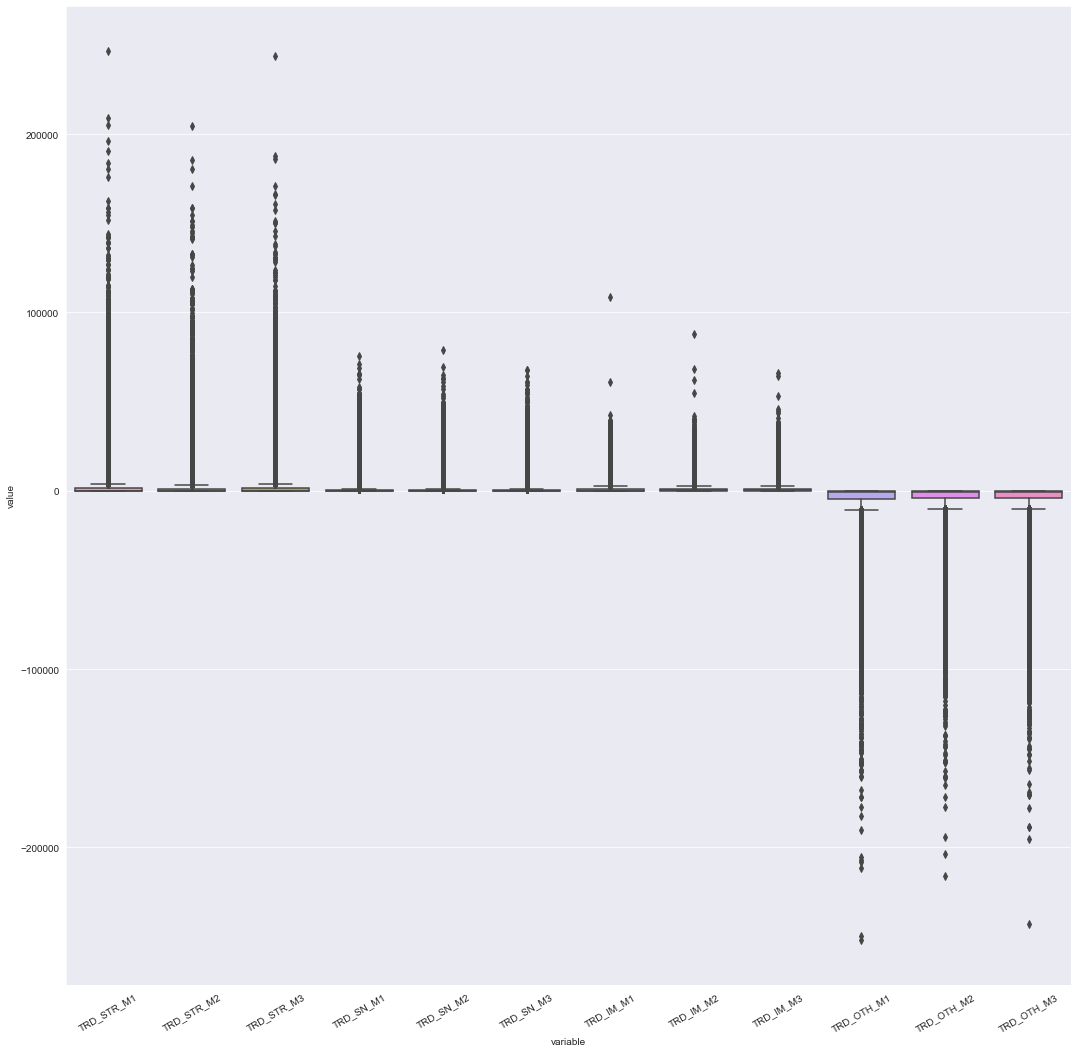

In [190]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_traffic_data_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Llamadas por voz

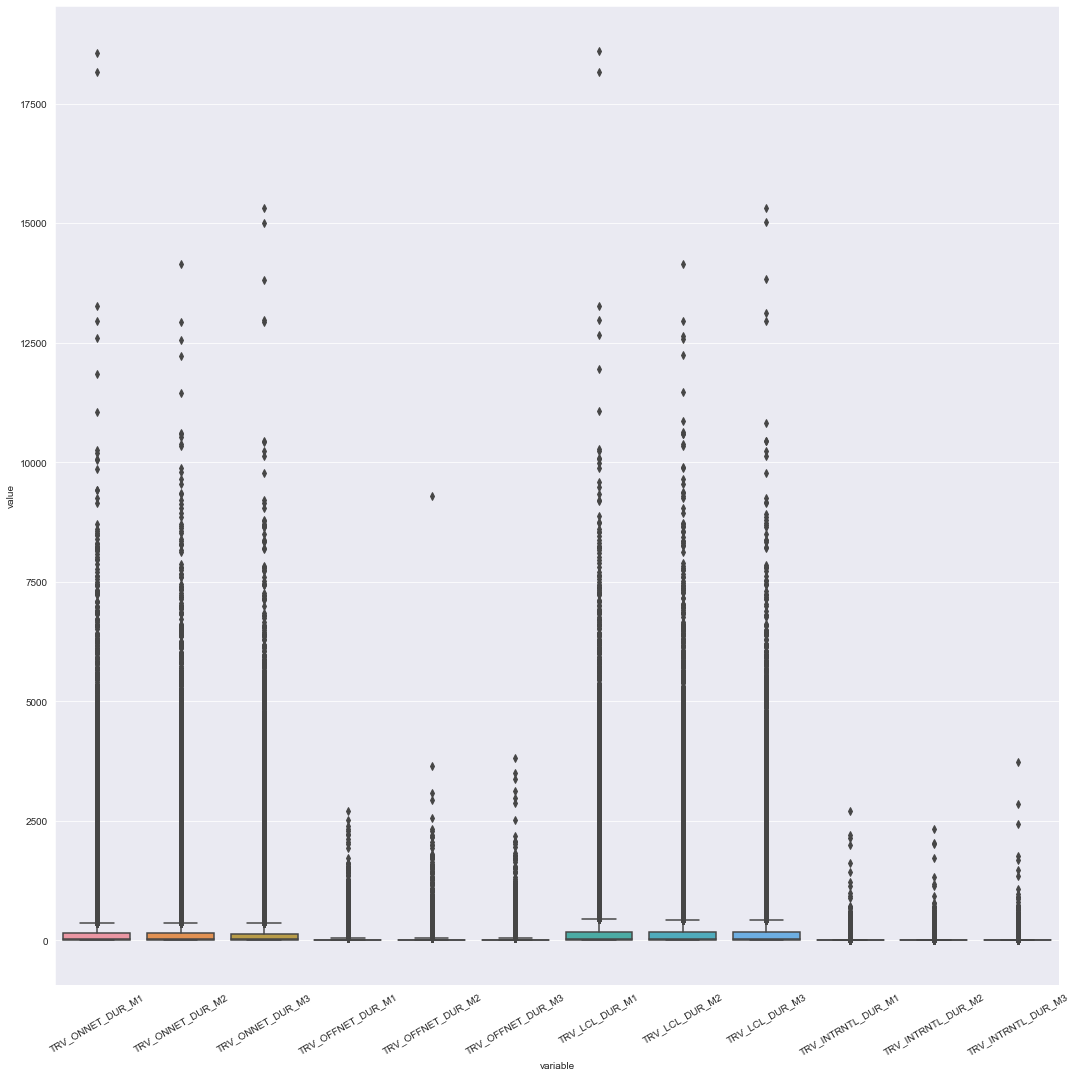

In [191]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_voice_minutes_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Sacando outliers

In [192]:
df_traffic_copy = df_traffic.copy()

In [193]:
df_traffic_data = pd.DataFrame()
for column in df_traffic[df_traffic_data_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_traffic_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


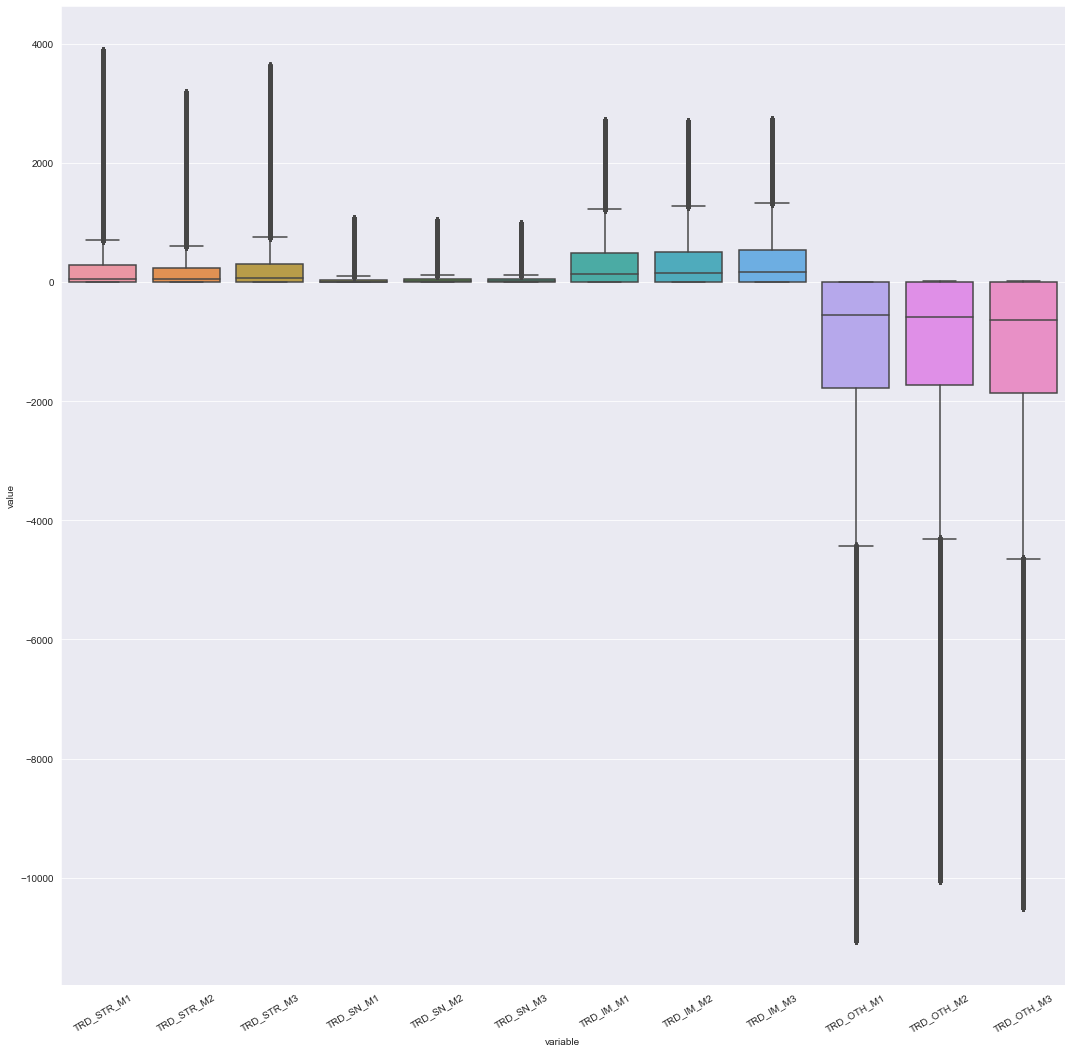

In [194]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [195]:
df_voice_data = pd.DataFrame()
for column in df_traffic[df_voice_minutes_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_voice_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


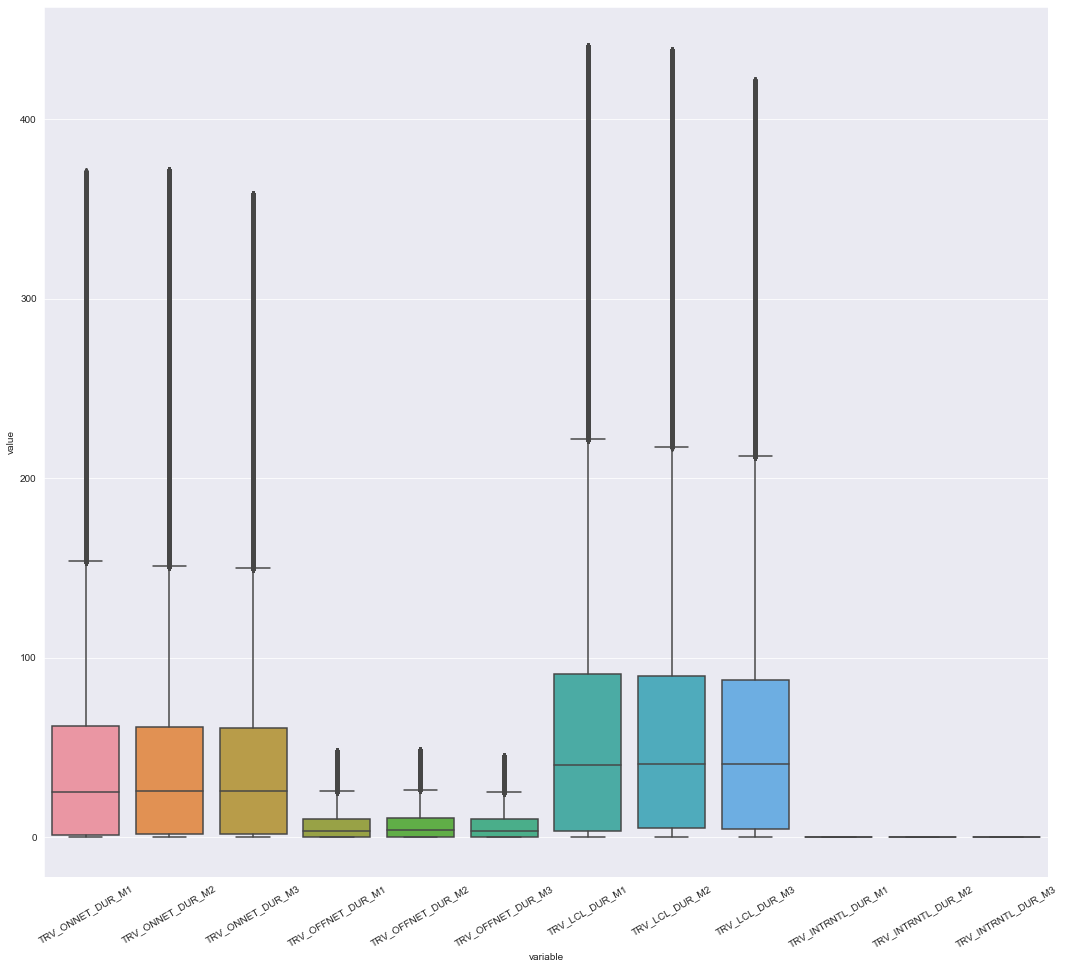

In [196]:
plt.figure(figsize=(18,16))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_voice_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

### Sacando datos de fulldata

In [197]:
fulldata.drop(columns=traffic_columns, inplace=True)

In [198]:
df_traffic.drop(columns=df_n_sms_columns, inplace=True)

In [199]:
fulldata.join(other=df_traffic)

,SUSCRIBER_KEY,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,TENURE_CUSTOMER_BL,PREP_RECH_Q_EVT_X1,...,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,E_63734494_20190215,8.58480,-82.38850,-82.43330,8.43330,3 - SILVER,2-PD,PD1,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,8,6,...,-13044.91,-1582.94,-863.00,139.53,188.60,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,E_66977552_20190518,8.58480,-82.38850,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,GALAXY GRAND PRIME DUOS (SM-G532M DS),SAMSUNG,LTE,18-MAY-19,5,5,0,...,0.00,0.00,0.00,0.00,0.00,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,E_69159695_20180116,8.12310,-81.07550,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,GALAXY GRAND PRIME DUOS (SM-G532M DS),SAMSUNG,3G,16-JAN-18,21,21,6,...,-296.58,0.00,-64.91,1.38,0.00,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,E_65255730_20190416,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,JENNY TV 2.8,BLU,LTE,16-APR-19,6,6,4,...,-119.86,0.00,0.00,1.17,0.00,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,E_67893872_20161201,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,DO3,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,35,4,...,-1349.20,-2888.10,-684.12,0.00,0.00,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,9.41650,-82.52070,-82.52000,9.43000,4 - BRONZE,7-LOW,LOW4,GALAXY GRAND NEO (GT-I9060C),SAMSUNG,LTE,21-JAN-19,9,9,0,...,0.00,-84.47,-167.11,0.00,0.00,1.12,0.00,0.00,2.32,0.00,0.00,3.43,0.0,0.0,0.0
319218,E_65347728_20171017,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,VD3,GALAXY J2 PRIME (SM-G532M),SAMSUNG,LTE,17-OCT-17,24,24,4,...,-1176.77,-3725.94,-3872.93,133.38,186.70,177.43,0.47,7.82,14.67,133.85,194.52,192.10,0.0,0.0,0.0
319219,E_68063707_20150701,8.79528,-80.14711,-79.65000,8.95000,3 - SILVER,6-OH,OH2,GT-E1205Q,SAMSUNG,LTE,01-JUL-15,52,52,6,...,0.00,0.00,0.00,91.50,28.77,36.33,1.00,1.07,0.42,92.50,29.83,36.75,0.0,0.0,0.0
319220,E_67206080_20181010,7.86810,-77.83670,-77.67270,8.13930,4 - BRONZE,7-LOW,VD1,Y9 2019 (JKM-LX3),HUAWEI,LTE,10-OCT-18,12,12,0,...,0.00,0.00,-3523.03,0.00,0.00,433.30,0.00,0.00,18.17,0.00,0.00,451.47,0.0,0.0,0.0


# Limpieza de datos de recargas

In [200]:
Recargas = fulldata[['PREP_RECH_Q_EVT_X1','PREP_RECH_Q_EVT_X2','PREP_RECH_Q_EVT_X3','PREP_RECH_AMT_X1',
                     'PREP_RECH_AMT_X2','PREP_RECH_AMT_X3', 'PREP_RECH_Q_MON_12W', 'PREP_RECH_Q_TUE_12W',
                    'PREP_RECH_Q_WEN_12W','PREP_RECH_Q_THUR_12W','PREP_RECH_Q_FRI_12W','PREP_RECH_Q_SAT_12W',
                    'PREP_RECH_Q_SUN_12W','PREP_RECH_NDAYS_LASTRECH_12W',
                    'PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3',
                    'PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7',
                    'PREP_RECH_Q_EVT_W8','PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11',
                    'PREP_RECH_Q_EVT_W12','PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3',
                    'PREP_RECH_AMT_W4','PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8',
                    'PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12']].copy()

In [201]:
Recargas.head(5)

,PREP_RECH_Q_EVT_X1,PREP_RECH_Q_EVT_X2,PREP_RECH_Q_EVT_X3,PREP_RECH_AMT_X1,PREP_RECH_AMT_X2,PREP_RECH_AMT_X3,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W,PREP_RECH_NDAYS_LASTRECH_12W,PREP_RECH_Q_EVT_W1,...,PREP_RECH_Q_EVT_W10,PREP_RECH_Q_EVT_W11,PREP_RECH_Q_EVT_W12,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
0,6,8,4,8.5,13.0,6.0,4,4,4,3,3,3,5,22,0,...,0,0,0,0.0,0.0,3.5,5.0,3.0,8.5,0.0,1.5,6.0,0.0,0.0,0.0
1,0,0,3,0.0,0.0,2.0,0,0,3,0,0,0,0,69,0,...,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,6,4,3,8.0,6.0,1.5,3,3,3,3,0,3,4,8,3,...,0,3,0,1.5,2.0,1.5,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.5,0.0
3,4,0,0,7.0,0.0,0.0,0,3,0,0,0,0,3,9,0,...,0,0,0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,3,13.0,10.0,10.0,0,3,3,3,0,4,0,5,3,...,3,0,0,3.0,0.0,0.0,10.0,0.0,5.0,0.0,5.0,0.0,10.0,0.0,0.0


In [202]:
Recargas[['PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W1'
          ,'PREP_RECH_Q_EVT_X1']].head(5)

,PREP_RECH_Q_EVT_W4,PREP_RECH_Q_EVT_W3,PREP_RECH_Q_EVT_W2,PREP_RECH_Q_EVT_W1,PREP_RECH_Q_EVT_X1
0,4,4,0,0,6
1,0,0,0,0,0
2,3,3,3,3,6
3,0,3,3,0,4
4,3,0,0,3,4


In [203]:
Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4','PREP_RECH_Q_EVT_W5',
          'PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8','PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10',
          'PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12','PREP_RECH_Q_EVT_X1','PREP_RECH_Q_EVT_X2','PREP_RECH_Q_EVT_X3']]

,PREP_RECH_Q_EVT_W1,PREP_RECH_Q_EVT_W2,PREP_RECH_Q_EVT_W3,PREP_RECH_Q_EVT_W4,PREP_RECH_Q_EVT_W5,PREP_RECH_Q_EVT_W6,PREP_RECH_Q_EVT_W7,PREP_RECH_Q_EVT_W8,PREP_RECH_Q_EVT_W9,PREP_RECH_Q_EVT_W10,PREP_RECH_Q_EVT_W11,PREP_RECH_Q_EVT_W12,PREP_RECH_Q_EVT_X1,PREP_RECH_Q_EVT_X2,PREP_RECH_Q_EVT_X3
0,0,0,4,4,3,6,0,3,4,0,0,0,6,8,4
1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3
2,3,3,3,3,0,4,0,0,0,0,3,0,6,4,3
3,0,3,3,0,0,0,0,0,0,0,0,0,4,0,0
4,3,0,0,3,0,3,0,3,0,3,0,0,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,5,0,0,0,5
319218,0,0,0,4,3,0,0,4,3,3,4,3,4,5,7
319219,3,0,3,4,0,3,3,3,0,0,0,3,6,5,3
319220,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3


In [204]:
Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4','PREP_RECH_AMT_W5',
         'PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8','PREP_RECH_AMT_W9','PREP_RECH_AMT_W10',
         'PREP_RECH_AMT_W11','PREP_RECH_AMT_W12','PREP_RECH_AMT_X1','PREP_RECH_AMT_X2','PREP_RECH_AMT_X3']].head(5)

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12,PREP_RECH_AMT_X1,PREP_RECH_AMT_X2,PREP_RECH_AMT_X3
0,0.0,0.0,3.5,5.0,3.0,8.5,0.0,1.5,6.0,0.0,0.0,0.0,8.5,13.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
2,1.5,2.0,1.5,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.5,0.0,8.0,6.0,1.5
3,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
4,3.0,0.0,0.0,10.0,0.0,5.0,0.0,5.0,0.0,10.0,0.0,0.0,13.0,10.0,10.0


# Vamos a comparar las cantidades de recargas acumuladas, con la cantidad de recargas acumuladas mensuales

In [205]:
Cant_rec_mes1= Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4'
                        ]].sum(axis=1)

In [206]:
Cant_rec_mes2= Recargas[['PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8'
                        ]].sum(axis=1)

In [207]:
Cant_rec_mes3= Recargas[['PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12'
                        ]].sum(axis=1)

In [208]:
(Cant_rec_mes1 == Recargas['PREP_RECH_Q_EVT_X1']).value_counts()

False    191491
True     127731
dtype: int64

In [209]:
(Cant_rec_mes2 == Recargas['PREP_RECH_Q_EVT_X2']).value_counts()

False    192949
True     126273
dtype: int64

In [210]:
(Cant_rec_mes3 == Recargas['PREP_RECH_Q_EVT_X3']).value_counts()

False    201542
True     117680
dtype: int64

Consideramos que la cantidad de datos que no coinciden es apreciable, entonces decidimos sacar los datos

In [211]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_W' in x],inplace=True)

# Vamos a comparar los montos de recargas acumuladas, con los montos de recargas acumuladas mensuales

In [212]:
Mont_rec_mes1= Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4'
                        ]].sum(axis=1)

In [213]:
Mont_rec_mes2= Recargas[['PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8'
                        ]].sum(axis=1)

In [214]:
Mont_rec_mes3= Recargas[['PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12'
                        ]].sum(axis=1)

In [215]:
(Mont_rec_mes1 == Recargas['PREP_RECH_AMT_X1']).value_counts()

True     319070
False       152
dtype: int64

In [216]:
(Mont_rec_mes2 == Recargas['PREP_RECH_AMT_X2']).value_counts()

True     319061
False       161
dtype: int64

In [217]:
(Mont_rec_mes3 == Recargas['PREP_RECH_AMT_X3']).value_counts()

True     319059
False       163
dtype: int64

Como los valores difieren en una cantidad indistinguible(menos del 1%) podemos conciderar que presentan la misma información. Por tal motivo se decide sacar las columnas de montos acumulados

In [218]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_AMT_X' in x],inplace=True)

In [219]:
fulldata.shape

(319222, 85)

### Entrenamos el modelo

In [254]:
y=fulldata.Target

In [255]:
columns = [col for col in fulldata.columns if col not in ['SUSCRIBER_KEY','Target']]

In [256]:
X = fulldata[columns]

In [257]:
X= X.select_dtypes(include=['int64','float64'])

In [258]:
from sklearn.model_selection import train_test_split 

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [260]:
X.shape

(319222, 74)

In [261]:
y.shape

(319222,)

In [262]:
X_train.shape

(223455, 74)

In [263]:
y_train.shape

(223455,)

In [264]:
X_test.shape

(95767, 74)

In [265]:
y_test.shape

(95767,)

Carga del modelo

In [266]:
xgb_model = xgb.XGBClassifier()

Entrenamiento del modelo

In [267]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Prediccion del modelo

In [268]:
XGB_preds = xgb_model.predict(X_test)

In [269]:
XGB_preds

array([0, 0, 0, ..., 0, 1, 1])

Visualizacion de resultados

In [270]:
print(classification_report(y_test, XGB_preds))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     69909
           1       0.70      0.68      0.69     25858

    accuracy                           0.83     95767
   macro avg       0.79      0.78      0.79     95767
weighted avg       0.83      0.83      0.83     95767



Analizamos la matriz de confusion

In [271]:
print(confusion_matrix(y_test, XGB_preds))

[[62413  7496]
 [ 8364 17494]]


In [ ]:
def train(X_train,y_train):
    """
    Función para entrenar el modelo.
    
    Parameters
    -----------
    
    X_train: pd.DataFrame
        Dataset de Train, listo para entrenar y sin tag
        
    y_train: pd.DataFrame
        Dataset de tag, es el tag correspondiente al dataset de train.
        
    Return
    ----------
    Modelo Entrenado.
    
    """
    xgb_model = xgb.XGBClassifier()

    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(X_train, y_train)

    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    XGB_preds = xgb_model.predict(X_test)
    print(classification_report(y_test, XGB_preds))
    print(confusion_matrix(y_test, XGB_preds))
    return xgb_model

In [ ]:
def predict(data_to_predict, xgb_model):
    """Funcion para hacer el entrenamiento del modelo y guardarlo en un archivo .pkl

    Parameters
    -----------

    data_to_predict : pd.DataFrame
        DataFrame listo para predecir, con las mismas transformaciones que el de entrenamiento.
        
    xgb_model : xgb.XGBClassifier
        Modelo entrenado de XGBoost

    Return
    -----------
    Dataframe de 3 columnas, la identificacion del cliente, la prediccion de la clase y la probabilidad de que el cliente
    permanezca en el servicio.


    """
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(X)
    
    return XGB_preds

In [ ]:
modelo = train(X_train, y_train)

In [97]:
resultado = predict(data,modelo)

NameError: name 'predict' is not defined